In [20]:
import geopandas as gpd
from shapely import wkt
from collections import defaultdict
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import itertools
import json

### Load Data

In [2]:
def normalize_point(pt, ndigits=7):
    x, y = pt  
    return (round(x, ndigits), round(y, ndigits))

In [3]:
df = gpd.pd.read_csv("knowledge_base/streets.csv").drop(columns = ["Unnamed: 0"])

In [4]:
df.columns

Index(['id', 'oficial_name', 'map_name', 'street_type', 'distance',
       'direction', 'neighborhood', 'geometry'],
      dtype='object')

In [5]:
# Change to WTK Object
df["geometry"] = df["geometry"].apply(wkt.loads)

### Create Graph

In [6]:
# Graph represented by adjency list.
# Nodes adn edges attributes stored separetlry.

# Initialize variables
street_graph = defaultdict(list)
edges = {}         # edge_id -> edge attributes
nodes = {}         # node_id -> {"coord": (lon, lat), "type": "intersection"}
coord_to_id = {}   # map coordinate to node_id 
next_node_id = itertools.count(1)

# Fill graph
for idx, row in df.iterrows():
    geom = row["geometry"]
    start_coord = normalize_point(geom.coords[0])
    end_coord   = normalize_point(geom.coords[-1])
    
    # Assign node IDs
    if start_coord not in coord_to_id:
        start_id = next(next_node_id)
        coord_to_id[start_coord] = start_id
        nodes[start_id] = {"coord": start_coord, "type": "intersection"}
    else:
        start_id = coord_to_id[start_coord]

    if end_coord not in coord_to_id:
        end_id = next(next_node_id)
        coord_to_id[end_coord] = end_id
        nodes[end_id] = {"coord": end_coord, "type": "intersection"}
    else:
        end_id = coord_to_id[end_coord]
    
    # Store edge attributes
    edge_attrs = {
        "oficial_name": row["oficial_name"],
        "map_name": row["map_name"],
        "street_type": row["street_type"],
        "distance": row["distance"],
        "direction": row["direction"],
        "neighborhood": row["neighborhood"],
        "geometry": row["geometry"],
        "u": start_id,
        "v": end_id
    }
    edges[row["id"]] = edge_attrs

    # Update adjacency list based on direction
    direction = row["direction"]
    if direction == "creciente":
        street_graph[start_id].append((end_id, row["id"]))
    elif direction == "decreciente":
        street_graph[end_id].append((start_id, row["id"]))
    else:  # Two-Way road
        street_graph[start_id].append((end_id, row["id"]))
        street_graph[end_id].append((start_id, row["id"]))


In [7]:
print("graph:", len(street_graph))
print("nodes:", len(nodes))
print("edges:", len(edges))

graph: 17665
nodes: 17717
edges: 30756


### Entire graph grouped by neightborhoods

/var/folders/yn/mgz4fxbx6ts1cp504y2cl4880000gn/T/ipykernel_13791/1261902289.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_colors)


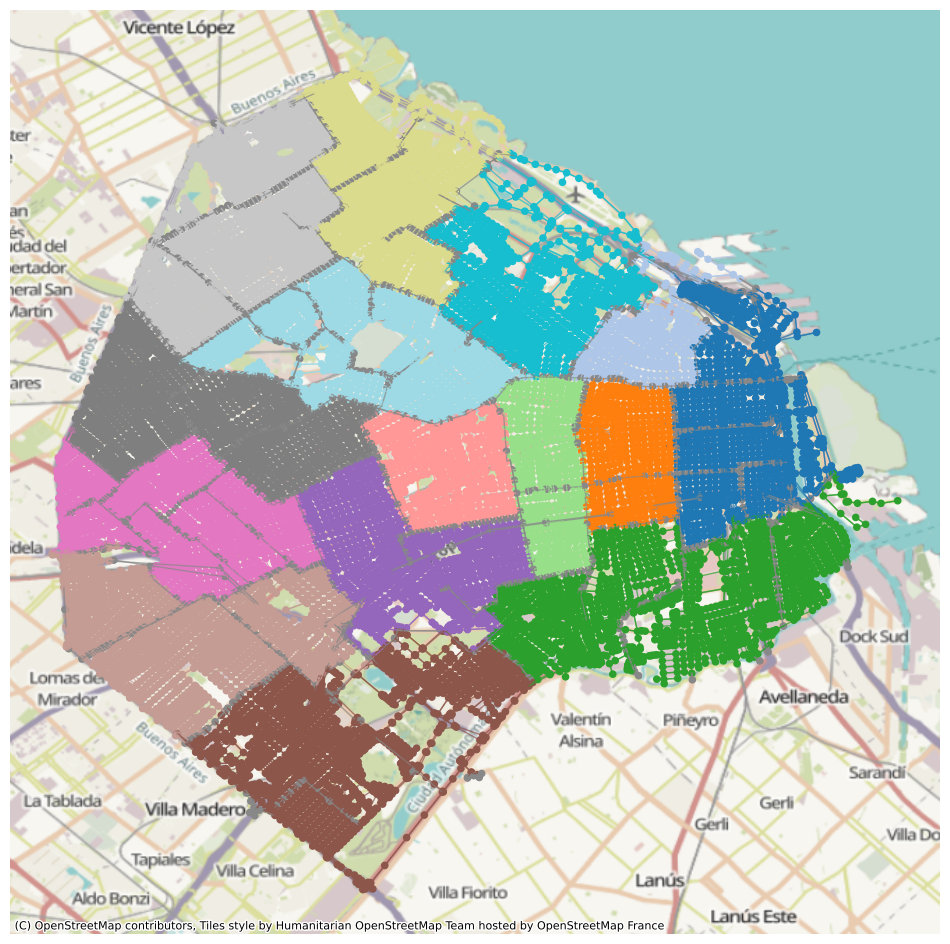

In [18]:
neighborhoods = list(range(1, 16))  
n_colors = len(neighborhoods)
cmap = cm.get_cmap('tab20', n_colors)  
color_map = {unique_neighborhood: mcolors.to_hex(cmap(i)) for i, unique_neighborhood in enumerate(neighborhoods)}
nan_color = '#888888'  

fig, ax = plt.subplots(figsize=(12,12))
for u_id, neighbors in street_graph.items():
    u_coord = nodes[u_id]['coord']  # get coordinates from nodes 
    for v_id, edge_id in neighbors:
        v_coord = nodes[v_id]['coord']
        unique_neighborhood = edges[edge_id]['neighborhood']
        if np.isnan(unique_neighborhood):
            color = nan_color
        else:
            color = color_map[int(unique_neighborhood)]
        ax.plot([u_coord[0], v_coord[0]], [u_coord[1], v_coord[1]], color=color, alpha=0.7, linewidth=1)

node_colors = []
x_nodes, y_nodes = [], []
for u_id, neighbors in street_graph.items():
    u_coord = nodes[u_id]['coord']
    x_nodes.append(u_coord[0])
    y_nodes.append(u_coord[1])
    if neighbors:
        unique_neighborhood = edges[neighbors[0][1]]['neighborhood']
        color = nan_color if np.isnan(unique_neighborhood) else color_map[int(unique_neighborhood)]
    else:
        color = nan_color
    node_colors.append(color)

ax.scatter(x_nodes, y_nodes, s=20, color=node_colors)

# Base Map
ctx.add_basemap(ax, crs="EPSG:4326")
ax.set_axis_off()
plt.show()

### Individual neighborhood

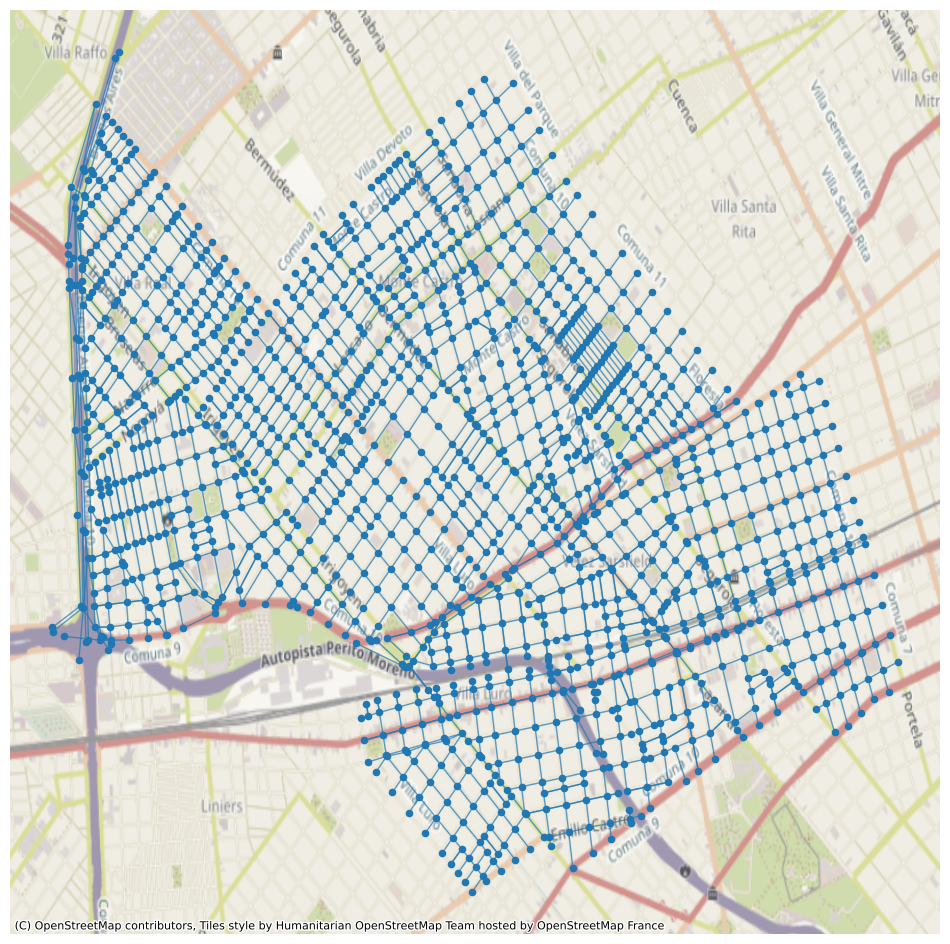

In [19]:
target_unique_neighborhood = 10
color = '#1f77b4'  

# Filter edges based on neighborhood
edges_to_plot = set()
for u_id, neighbors in street_graph.items():
    for v_id, edge_id in neighbors:
        unique_neighborhood = edges[edge_id]['neighborhood']
        if not np.isnan(unique_neighborhood) and int(unique_neighborhood) == target_unique_neighborhood:
            edges_to_plot.add((u_id, v_id))

# Extract nodes
nodes_to_plot = set()
for u_id, v_id in edges_to_plot:
    nodes_to_plot.add(u_id)
    nodes_to_plot.add(v_id)


fig, ax = plt.subplots(figsize=(12,12))

# Plot Edges
for u_id, v_id in edges_to_plot:
    u_coord = nodes[u_id]['coord']
    v_coord = nodes[v_id]['coord']
    ax.plot([u_coord[0], v_coord[0]], [u_coord[1], v_coord[1]], color=color, alpha=0.7, linewidth=1)

# Plotes nodes
x_nodes, y_nodes = [], []
for node_id in nodes_to_plot:
    coord = nodes[node_id]['coord']
    x_nodes.append(coord[0])
    y_nodes.append(coord[1])
ax.scatter(x_nodes, y_nodes, s=20, color=color)

# Add Base Map
ctx.add_basemap(ax, crs="EPSG:4326")
ax.set_axis_off()
plt.show()


### Save graph and data

In [25]:
# Convert Edges
edges_json = {}
for edge_id, data in edges.items():
    data_copy = data.copy()
    geom = data_copy.get("geometry")
    if geom:
        data_copy["geometry"] = geom.wkt  
    edges_json[edge_id] = data_copy

# Convert street_graph keys to strings
street_graph_json = {str(k): v for k, v in street_graph.items()}

# Nodes to strings
nodes_json = {str(k): v for k, v in nodes.items()}

# Sve everything
with open("knowledge_base/graph_data.json", "w") as f:
    json.dump({
        "nodes": nodes_json,
        "edges": edges_json,
        "graph": street_graph_json
    }, f, indent=2)